# **OmniXAS Tutorial**

Welcome! Here is a jupyter notebook that shows you how to use OmniXAS to train a neural network on feature and spectral data. We show you how to do everything step by step and explain important details of the code that help you use it smoother. We show two examples cases. One where we go from start to finish training a neural network using the published data, training splits, and neural network structures. This example gives you a good feel of the code's basic workings. Then, we give an example of how to use your own data with OmniXAS to train your own neural network. We also go over options to use Optuna hyperparameter tuning to efficiently search the hyperparameter space for the best NN structure for your specific data. 

**If you have any questions, concerns, or suggestions for improvement please reach out to: Shubha Kharel (author, shubha.raj.kharel@gmail.com), Deyu Lu (author and PI, dlu@bnl.gov), and Nina Cao (Developer of this Tutorial, ncao1023@mit.edu)**

## **Import Important Libraries**

Using OmniXAS requires the use of several basic libearies. When importing OmniXAS, we advise directly importing several important functions listed below. Outisde of OmniXAS, basic libraries like numpy and matplotlib are imported, as well as optuna and pymatgen.


In [4]:
import omnixas
from omnixas.data.xas import ElementSpectrum, IntensityValues, Material, EnergyGrid
from omnixas.data.scaler import ScaledMlSplit,ThousandScaler
from omnixas.core.periodic_table import Element, SpectrumType
from omnixas.featurizer.m3gnet_featurizer import M3GNetSiteFeaturizer, M3GNetFeaturizer
from omnixas.model.xasblock_regressor import XASBlockRegressor
from omnixas.data.ml_data import MLData, MLSplits
from omnixas.data.material_split import MaterialSplitter

import os
import optuna
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core.structure import Structure


## **Train with Predefined Splits and Hyperparameters**

The first thing we do is pull all material ID and site ID information from the data available in OmniXAS. We use Copper (Cu) as the example element throughout this notebook. We read ID data from the train, test, and validation sets for materials with Cu that FEFF spectra were generated for. We combine all ID info into one large list.


In [56]:
with open("material_id_and_site/Cu_FEFF_train.txt", 'r') as file:
    lines = file.readlines()
    lst = [line.strip() for line in lines]
    # print(len(lst))

with open("material_id_and_site/Cu_FEFF_test.txt", 'r') as file:
    lines = file.readlines()
    lst2 = [line.strip() for line in lines]
    # print(len(lst2))

with open("material_id_and_site/Cu_FEFF_val.txt", 'r') as file:
    lines = file.readlines()
    lst3 = [line.strip() for line in lines]
    # print(len(lst3))

lst = lst + lst2
lst = lst + lst3

From the list above of material and site IDs, we separate the two ID types into separate lists. Since each element in lst is a concatenated string of material ID and site ID and we want those two characteristics separate:


In [57]:
matids = []
sites = []
for i in range(len(lst)): 
    matids.append(lst[i][:-4]) 
    sites.append(int(lst[i][-3:]))

Now that we have material and site ID information, we can load our feature (X) and spectral (y) data. This metadata won't be used to train the neural network, but it's helpful to know how to pull the information and have it in case you need to perform more complex functions on data that require such information. Moving onto the main part of the section.

In the ml_data folder, we have both input values for train, test, and validation sets (which are features) as well as output values (which are spectra). We read the files and store training, test, and validation features in separate lists from the appropriate "_X.txt" files. We then convert the elements of each list into float values to make sure that our features are arrays of floats rather than strings or other data types.

In [7]:
with open("ml_data/Cu_FEFF_train_X.txt", 'r') as file:
    lines = file.readlines()
    fts = [line.strip() for line in lines]

with open("ml_data/Cu_FEFF_test_X.txt", 'r') as file:
    lines = file.readlines()
    fts2 = [line.strip() for line in lines]

with open("ml_data/Cu_FEFF_val_X.txt", 'r') as file:
    lines = file.readlines()
    fts3 = [line.strip() for line in lines]

training_features = fts
test_features = fts2
validation_features = fts3

for i in range(len(training_features)):
    float_list = list(map(float, training_features[i].split()))
    training_features[i] = float_list

for i in range(len(test_features)):
    float_list = list(map(float, test_features[i].split()))
    test_features[i] = float_list

for i in range(len(validation_features)):
    float_list = list(map(float, validation_features[i].split()))
    validation_features[i] = float_list

We do the same thing for spectra data, which is output data. This output data is stored in "_y.txt" files and we keep training, test, and validation lists separate as we did for the feature data.

In [8]:
with open("ml_data/Cu_FEFF_train_y.txt", 'r') as file:
    lines = file.readlines()
    spc = [line.strip() for line in lines]

with open("ml_data/Cu_FEFF_test_y.txt", 'r') as file:
    lines = file.readlines()
    spc2 = [line.strip() for line in lines]

with open("ml_data/Cu_FEFF_val_y.txt", 'r') as file:
    lines = file.readlines()
    spc3 = [line.strip() for line in lines]

training_spectra = spc
test_spectra = spc2
validation_spectra = spc3

for i in range(len(training_spectra)):
    float_list = list(map(float, training_spectra[i].split()))
    training_spectra[i] = float_list

for i in range(len(test_spectra)):
    float_list = list(map(float, test_spectra[i].split()))
    test_spectra[i] = float_list

for i in range(len(validation_spectra)):
    float_list = list(map(float, validation_spectra[i].split()))
    validation_spectra[i] = float_list

Next, we use OmniXAS's MLData function to combine train, test, and validation X and Y data from the lists we generated above. This function will compile the data into the right data type. These data splits can then be fed into MLSplits which handles splitting the data for use in a neural network down the line. This split "omnixas_split" is what is fit into the neural network. We define a neural network model with XASBlockRegressor, defining important hyperparameters such as hidden dimensions, max epochs, initial learning rate, and more. The cell below shows the published values that OmniXAS determined were best for Cu FEFF data. To actually train the neural network, we run model.fit(omnixas_split).

In [9]:
omnixas_train_data = MLData(
    X=training_features,
    y=training_spectra,
)
omnixas_val_data = MLData(
    X=validation_features,
    y=validation_spectra,
)
omnixas_test_data = MLData(
    X=test_features,
    y=test_spectra,
)

#put comment on scaling caveat and show function to scale spectra
omnixas_split = MLSplits(train=omnixas_train_data, val=omnixas_val_data, test=omnixas_test_data)

model = XASBlockRegressor(
    directory=f"checkpoints",
    max_epochs=100,
    early_stopping_patience=25,  # stops if val_loss does not improve for 25 epochs
    overwrite_save_dir=True,  # delete save_dir else adds new files to it
    input_dim=64, # feature dimension
    output_dim=141, # spectra dimension
    hidden_dims=[600,600,400], # widths of hidden layer of MLP
    initial_lr=0.0022819132648236825,  # initial learning rate, will be optimized by lr finder later
    batch_size=32,
)

model.fit(omnixas_split) # full split object needs to be passed coz it contains val data used in logging

2025-09-10 20:40:15.801 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/ninacao/Desktop/OmniXAS/omnixas/checkpoints exists and is not empty.
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01
Restoring states from the checkpoint path at checkpoints/.lr_find_4b723bf1-613d-4742-9b6c-c8da20d4e143.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_4b723bf1-613d-4742-9b6c-c8da20d4e143.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 699 K  | train
-------------------------------------------
699 K     Trainable params
0         Non-trainable params
699 K     Total params
2.799     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_4b723bf1-613d-4742-9b6c-c8da20d4e143.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 20:41:51.962 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=97-val_loss=0.0039.ckpt
2025-09-10 20:41:51.963 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.00397237716242671


Now that we have a trained NN, we can start to visualize its results and performance in terms of how well it fit the data. The first thing we'll do is visualize decile plots. These show a single example spectrum as well as the prediction output by the NN within each decile, where lower deciles refer to better matches between the ground truth and prediction. In order to do this, we pull the predicted spectra from the validation set along with the ground truth values (targets). We use OmniXAS's ModelMetrics class to pull multiple important metrics at a time and first print the MSE and the median of the MSE per spectrum.

In [11]:
from omnixas.model.metrics import ModelMetrics
predictions = model.predict(omnixas_split.val.X)
targets = omnixas_split.val.y
metrics = ModelMetrics(predictions=predictions, targets=targets) 
print(f"MSE: {metrics.mse}")
print(f"Median of mse of spectra: {metrics.median_of_mse_per_spectra}")

MSE: 0.003972376921618823
Median of mse of spectra: 0.0026024172605381133


/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


ModelMetrics also has a deciles functionality, which we will pull to make the decile plots. We plot each decile prediciton vs target in a different subplot. This shows us how well the model performed on average and how well it did in the best and worst case scenarios.

/var/folders/_w/8ybkhsj53jd8m81vzffxwt200000gn/T/ipykernel_79993/2891242730.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


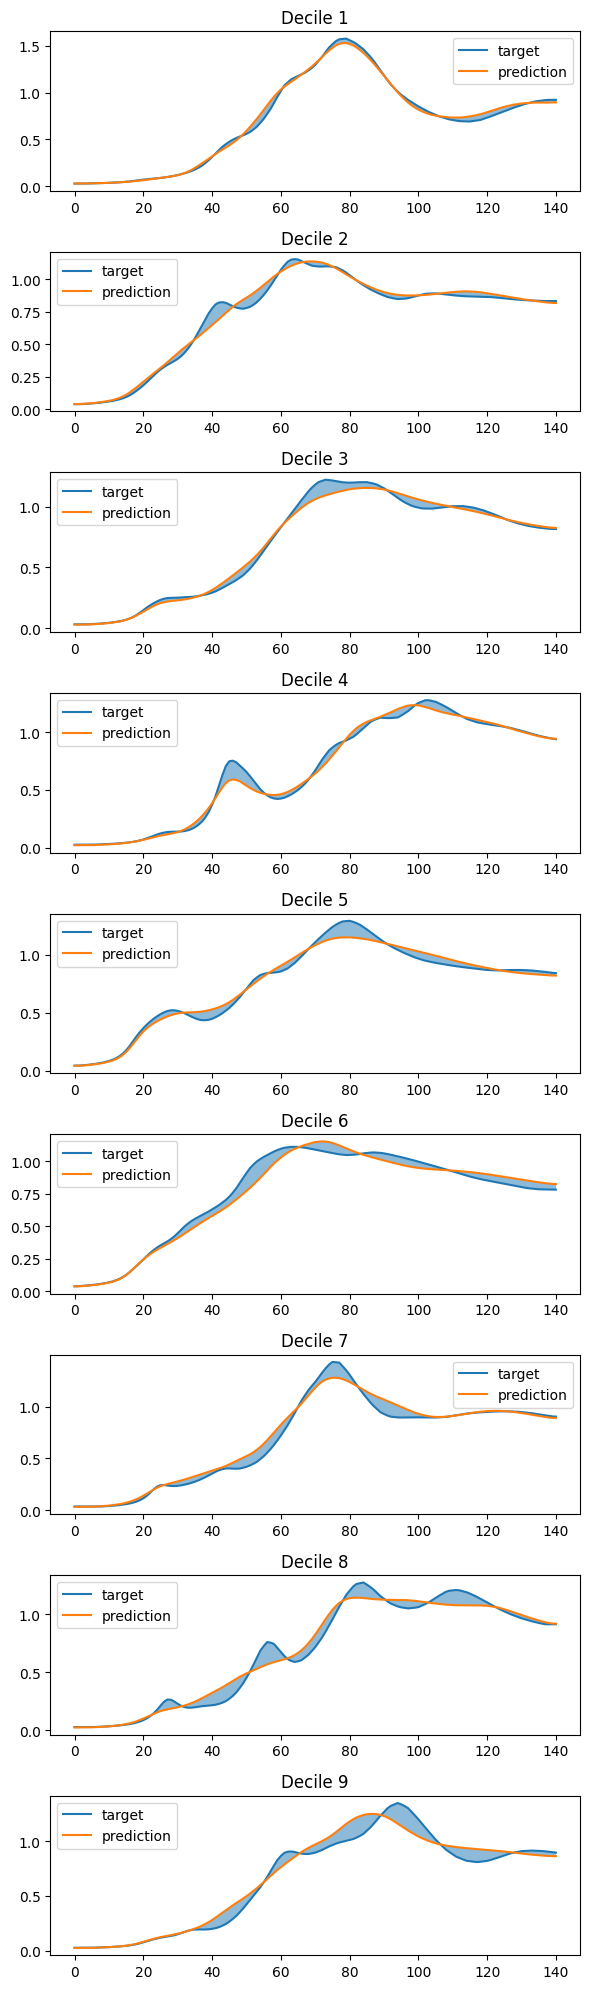

In [12]:
deciles = metrics.deciles
fig, axs = plt.subplots(9, 1, figsize=(6, 20))
for i, (d, ax) in enumerate(zip(deciles, axs)):
    ax.plot(d[0], label="target")
    ax.plot(d[1], label="prediction")
    ax.fill_between( range(len(d[0])), d[0], d[1], alpha=0.5, interpolate=True)
    ax.legend()
    ax.set_title(f"Decile {i+1}")
fig.tight_layout()
fig.show()

In addition to decile plots, we can also plot a histogram of the MSEs to visualize performance in a different way. We first pull the predictions and targets we stored using ModelMetrics. Then, we manually calculate the MSE for each individual target and prediction and store it in a list. Note that ModelMetrics also returns MSE but this is the aggregate MSE for all spectra and predictions. ModelMetrics also reutrns the mean MSE but does not return MSE for each target, prediction pair, which is why we do this manually here.

In [13]:
MSEs = []
preds = metrics.predictions
targs = metrics.targets

for i in range(len(preds)):
    target = targs[i]
    prediction = preds[i]

    error = target - prediction
    MSEs.append(np.mean(error**2))

Since most MSEs are very close to zero, we define our histogram bins logarithmically and visualize the histogram with the x axis log-scaled. This gives us a good representation of the distribution of performance for the model across the validation set.

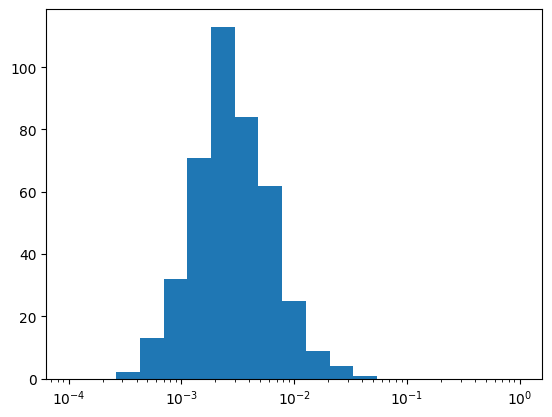

In [14]:
bins = 10**np.linspace(-4, 0, 20) # 20 bins from 10^0 to 10^3
plt.hist(MSEs, bins = bins)
plt.xscale('log')

## **Train with Your Own Splits**

Say, however, that you want to start from scratch and generate your own spectra and features with only matid, site ID, and structure information. Then you want to be able to find your own splits and train your NN that way. Here, we will show how to do that. In order to do this, you will need the following data:

- your own structures, material IDs, and site IDs
- your own spectral intensities per material ID and site ID
- a specified energy grid (which is uniform across all spectra)

For the purpose of this exercise, we pull the relevant infomation from a file tutorial_data/CU_FEFF.npz. This has pre-compiled data similar to some compiled data you may access in the future. In practice it is essentially the same data as what's used above in the previous section, but this is just for illustrative purposes. We will need to use this data later when generating spectral data types that can be used properly in OmniXAS. CU_FEFF.npz provides all important data except structure data, which we pull from a separate file below.

In [15]:
elemental_file = "CU_FEFF.npz"
elemental_data = np.load(elemental_file)

FEFF_IDs = elemental_data['ids']
FEFF_sites = elemental_data['sites']
FEFF_energies = elemental_data['energies']
FEFF_spectra = elemental_data['spectras']

We pull structure information from POSCAR files using pymatgen. Our POSCAR files are in the FEFF/Cu folder. In this directorty, we get the list of material IDs available from the name of each folder and then pull the relevant POSCAR file to calcualte the structure. We store structures in a dictionary.

In [17]:
Cu_mpids = os.listdir("../FEFF/Cu/")
published_structures = {}

for mpid in Cu_mpids:
    if mpid[0] != 'm':
        continue
    published_structure = Structure.from_file("../FEFF/Cu/"+mpid+"/POSCAR")
    published_structures[mpid] = published_structure

Now, from the structures we've pulled and the other information we've gathered, we can calculate features and spectra. We need to iterate through all material IDs and side IDs from FEFF_sites and FEFF_IDs. We also confirm that we only calculate feature and spectral data for IDs that are in CU_mpids, which just makes sure that we have the appropriate structure information for calculating features for every piece of spectral data we keep. The code to calculate spectra and features and store them in dictionaries (with material IDs and side IDs as two different levels of keys) below.

In [48]:
structs = published_structures
features = {}
spectra = {}

for i in range(len(FEFF_IDs)):

    ID = FEFF_sites[i]
    mat = FEFF_IDs[i]
    
    if mat not in Cu_mpids:
        continue

    if mat not in features.keys():
        features[mat] = {}

    if mat not in spectra.keys():
        spectra[mat] = {}
    
    struct = structs[mat]

    spectrum = ElementSpectrum(
        element=Element.Cu,
        type=SpectrumType.FEFF,
        index=ID,
        material= Material( id = mat, structure = struct),
        intensities=IntensityValues(FEFF_spectra[i]*1000),
        energies=EnergyGrid(root=FEFF_energies),
    )

    # featurize material structure corresponding to the spectrum_1
    feature = M3GNetSiteFeaturizer().featurize(spectrum.material.structure, spectrum.index)

    features[mat][str(ID)] = feature*1000
    spectra[mat][str(ID)] = spectrum.intensities

Once we've generated our feature and spectrum dictionaries, we use MaterialSplitter to split the data by material ID and side ID using a random seed and our desired split fractions. This split function will return ID pairs filtrered into either the training, test, or validation sets.

In [49]:
idSite = [(FEFF_IDs[i], FEFF_sites[i]) for i in range(len(FEFF_IDs))]
split_idSite = MaterialSplitter.split(
    idSite=idSite,
    target_fractions=[0.7,0.2,0.1],
    seed=762345
)

#look into structure based splits, check if material splitter siphon by same material. Site indices that are with same materials all in same set. Same structure shares
#info, so splitting into different sets is a problem of data leaking. Materials split in paper. What if you don't have material id? Maybe have to rewrite for more general case.

train_idSite, val_idSite, test_idSite = split_idSite

Once we have split our ID pairs into the right set, we pull the features and spectra related to each ID site pair from our created dictionaries and create training, test, and validation datasets using MLData. We then define our split object using MLSplits.

In [50]:
train_data = MLData(
    X=[features[id][site] for id, site in train_idSite],
    y=[spectra[id][site] for id, site in train_idSite],
)
val_data = MLData(
    X=[features[id][site] for id, site in val_idSite],
    y=[spectra[id][site] for id, site in val_idSite],
)
test_data = MLData(
    X=[features[id][site] for id, site in test_idSite],
    y=[spectra[id][site] for id, site in test_idSite],
)

split = MLSplits(train=train_data, val=val_data, test=test_data)

You can now either test manually different NN hyperparameters or use Optuna to do a hyperparameter search. If you're not interested in hyperparameter tuning, skip the Optuna tab.

### Optuna

To do hyperparameter tuning, we need to define an objective function for Optuna to minimize. Essentially, in the objective function, we'll define the hyperparameters we want to tune, the ranges we want to sample from for each hyperparameter, and feed that into a model for each trial. We then train the trial model and calculate the aggregate mse as the objective we want Optuna to use to determine the quality of the tested hyperparameter set. Feel free to play around with parameter ranges, what other hyperparameters you want to optimize (maybe max epochs or something else), and also the specific variable the objective minimizes (maybe try minimizing median MSE per spectra and compare performance, or something entirely different).

In [44]:
def objective(trial):
    try:
        # Suggest architecture
        num_layers = trial.suggest_int("num_layers", 1, 10)
        layer_widths = [trial.suggest_categorical(f"layer_{i}_width", np.arange(50,1000,10)) for i in range(num_layers)]

        # Suggest batch size
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128,2**8,2**9,2**10])
        
        # Suggest learning rate
        lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

        model = XASBlockRegressor(
            directory=f"checkpoints",
            max_epochs=100,
            early_stopping_patience=25,  # stops if val_loss does not improve for 25 epochs
            overwrite_save_dir=True,  # delete save_dir else adds new files to it
            input_dim=64, # feature dimension
            output_dim=141, # spectra dimension
            hidden_dims=layer_widths, # widths of hidden layer of MLP
            initial_lr=lr,  # initial learning rate, will be optimized by lr finder later
            batch_size=batch_size,
        )

        model.fit(split)

        predictions = model.predict(split.val.X)
        targets = split.val.y
        metrics = ModelMetrics(predictions=predictions, targets=targets)

        return metrics.mse  # Lower is better (for MAE/RMSE)
    except Exception as e:
        print(f"Trial {trial.number} failed due to: {e}")
        return np.inf

We create a study where we want to specificially minimize the objective function (in our case minimize MSE), and then specifically optimize the hyperparameter set defined in the objective. We run 10 trials.

In [45]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-09-10 21:20:52,010] A new study created in memory with name: no-name-38b4264a-ae1c-4ed0-acf3-b574aa8003ad
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 50 which is of type int64.
  warnings.warn(message)
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 60 which is of type int64.
  warnings.warn(message)
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 70 which is of type int64.
  warnings.warn(message)
/Users/nin

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at checkpoints/.lr_find_37ec4ef2-1a5a-4b51-be5c-16a62f637d78.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_37ec4ef2-1a5a-4b51-be5c-16a62f637d78.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 181 K  | train
-------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.724     Total estimated model params size (MB)
8         Modules in train mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 21:21:10.614 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=99-val_loss=0.0053.ckpt
2025-09-10 21:21:10.615 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.00526000140234828
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
[I 2025-09-10 21:21:10,749] Trial 0 finished with value: 0.0052600010852929145 and parameters: {'num_layers': 1, 'layer_0_width': 870, 'batch_size': 128, 'lr': 0.00021934186292184925}. Best is trial 0 with value: 0.0052600010852929145.
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/optuna/distributions.py:515: User

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at checkpoints/.lr_find_042fc77c-c846-4cc3-919f-dbeb721cb315.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_042fc77c-c846-4cc3-919f-dbeb721cb315.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 1.3 M  | train
-------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.185     Total estimated model params size (MB)
24        Modules in train mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 21:22:17.090 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=99-val_loss=0.0070.ckpt
2025-09-10 21:22:17.090 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.007029757369309664
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
[I 2025-09-10 21:22:17,352] Trial 1 finished with value: 0.007029757371991053 and parameters: {'num_layers': 5, 'layer_0_width': 460, 'layer_1_width': 460, 'layer_2_width': 770, 'layer_3_width': 740, 'layer_4_width': 140, 'batch_size': 256, 'lr': 0.00016672186754630014}. Best is trial 0 with value: 0.0052600010852929145.
/Users/ninacao/o

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at checkpoints/.lr_find_f6347b1e-9de6-496c-bb66-6391167dbd60.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_f6347b1e-9de6-496c-bb66-6391167dbd60.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 2.5 M  | train
-------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.075    Total estimated model params size (MB)
44        Modules in train mode
0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-09-10 21:24:04,948] Trial 2 finished with value: inf and parameters: {'num_layers': 10, 'layer_0_width': 730, 'layer_1_width': 340, 'layer_2_width': 990, 'layer_3_width': 780, 'layer_4_width': 180, 'layer_5_width': 710, 'layer_6_width': 680, 'layer_7_width': 260, 'layer_8_width': 530, 'layer_9_width': 50, 'batch_size': 256, 'lr': 3.060667777180081e-05}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:24:04.956 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 2 failed due to: name 'exit' is not defined


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at checkpoints/.lr_find_d45d39e0-216b-41d4-956b-7dd7958cde1c.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_d45d39e0-216b-41d4-956b-7dd7958cde1c.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 2.0 M  | train
-------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.980     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_d45d39e0-216b-41d4-956b-7dd7958cde1c.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-09-10 21:24:20,548] Trial 3 finished with value: inf and parameters: {'num_layers': 9, 'layer_0_width': 660, 'layer_1_width': 50, 'layer_2_width': 900, 'layer_3_width': 500, 'layer_4_width': 560, 'layer_5_width': 740, 'layer_6_width': 610, 'layer_7_width': 210, 'layer_8_width': 390, 'batch_size': 32, 'lr': 0.0002980593314901681}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:24:20.551 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 3 failed due to: name 'exit' is not defined


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at checkpoints/.lr_find_28cba110-b7fd-4db6-913a-c15c1cdfbb9f.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_28cba110-b7fd-4db6-913a-c15c1cdfbb9f.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 266 K  | train
-------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.068     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_28cba110-b7fd-4db6-913a-c15c1cdfbb9f.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 21:24:38.851 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=97-val_loss=0.0065.ckpt
2025-09-10 21:24:38.851 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.006613662000745535
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
[I 2025-09-10 21:24:38,997] Trial 4 finished with value: 0.006613662228328423 and parameters: {'num_layers': 2, 'layer_0_width': 290, 'layer_1_width': 570, 'batch_size': 1024, 'lr': 0.0010681273061358394}. Best is trial 0 with value: 0.0052600010852929145.
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/optuna/dist

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at checkpoints/.lr_find_9251aa64-300a-4158-bdbf-254e1a61c6c5.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_9251aa64-300a-4158-bdbf-254e1a61c6c5.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 991 K  | train
-------------------------------------------
991 K     Trainable params
0         Non-trainable params
991 K     Total params
3.966     Total estimated model params size (MB)
12        Modules in train mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-09-10 21:25:52,076] Trial 5 finished with value: inf and parameters: {'num_layers': 2, 'layer_0_width': 850, 'layer_1_width': 940, 'batch_size': 32, 'lr': 7.147673489355112e-05}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:25:52.086 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 5 failed due to: name 'exit' is not defined


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at checkpoints/.lr_find_cb88b16b-04a2-425f-b476-191731f8e973.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_cb88b16b-04a2-425f-b476-191731f8e973.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 2.1 M  | train
-------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.331     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_cb88b16b-04a2-425f-b476-191731f8e973.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2025-09-10 21:26:18,289] Trial 6 finished with value: inf and parameters: {'num_layers': 7, 'layer_0_width': 850, 'layer_1_width': 760, 'layer_2_width': 840, 'layer_3_width': 240, 'layer_4_width': 190, 'layer_5_width': 970, 'layer_6_width': 270, 'batch_size': 1024, 'lr': 0.0033127803639521457}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:26:18.298 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 6 failed due to: Got <class 'NoneType'>, but numpy array, torch tensor, or caffe2 blob name are expected.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01
Restoring states from the checkpoint path at checkpoints/.lr_find_81aa8e6e-311e-4ba3-a9ca-68c5a7b0311f.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_81aa8e6e-311e-4ba3-a9ca-68c5a7b0311f.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 2.1 M  | train
-------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.244     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_81aa8e6e-311e-4ba3-a9ca-68c5a7b0311f.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-09-10 21:26:27,851] Trial 7 finished with value: inf and parameters: {'num_layers': 6, 'layer_0_width': 310, 'layer_1_width': 600, 'layer_2_width': 940, 'layer_3_width': 810, 'layer_4_width': 350, 'layer_5_width': 480, 'batch_size': 16, 'lr': 0.002406381429275004}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:26:27.859 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 7 failed due to: name 'exit' is not defined


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0022908676527677745
Restoring states from the checkpoint path at checkpoints/.lr_find_0f3d2358-d39b-4c86-9f15-9a34515d5ba0.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_0f3d2358-d39b-4c86-9f15-9a34515d5ba0.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 1.7 M  | train
-------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.758     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_0f3d2358-d39b-4c86-9f15-9a34515d5ba0.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-09-10 21:26:41,411] Trial 8 finished with value: inf and parameters: {'num_layers': 7, 'layer_0_width': 990, 'layer_1_width': 420, 'layer_2_width': 440, 'layer_3_width': 710, 'layer_4_width': 570, 'layer_5_width': 140, 'layer_6_width': 770, 'batch_size': 16, 'lr': 0.0007604997874141462}. Best is trial 0 with value: 0.0052600010852929145.
2025-09-10 21:26:41.413 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.


Trial 8 failed due to: name 'exit' is not defined


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at checkpoints/.lr_find_76266d67-5f8a-4d5b-9573-705417a90a82.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_76266d67-5f8a-4d5b-9573-705417a90a82.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 78.0 K | train
-------------------------------------------
78.0 K    Trainable params
0         Non-trainable params
78.0 K    Total params
0.312     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_76266d67-5f8a-4d5b-9573-705417a90a82.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 21:26:51.162 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=99-val_loss=0.1377.ckpt
2025-09-10 21:26:51.162 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.13772094249725342
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
[I 2025-09-10 21:26:51,321] Trial 9 finished with value: 0.13772094302201107 and parameters: {'num_layers': 2, 'layer_0_width': 300, 'layer_1_width': 130, 'batch_size': 1024, 'lr': 1.073130347590149e-05}. Best is trial 0 with value: 0.0052600010852929145.


After the trials, we can ask the study to tell us what the best hyperparameters it found were and what the model's performance was with those hyperparameters.

In [ ]:
print('Best hyperparameters: ', study.best_params)
print('Best performance: ', study.best_value)

Best hyperparameters:  {'num_layers': 9, 'layer_0_width': 440, 'layer_1_width': 170, 'layer_2_width': 700, 'layer_3_width': 890, 'layer_4_width': 620, 'layer_5_width': 810, 'layer_6_width': 170, 'layer_7_width': 800, 'layer_8_width': 520, 'batch_size': 128, 'lr': 0.0058269734961239805}
Best performance:  3.573005522640776e-07


You can now input these hyperparameters into your NN in the "Training the NN and Visualizing Data" section if you wish!

### Training the NN and Visualizing Data

The rest of the code is the same as previously, we define our NN model, train it, and then visualize various different performance metrics. You can compare your NN model to what was published above! Happy testing!

In [51]:
model = XASBlockRegressor(
    directory=f"checkpoints",
    max_epochs=100,
    early_stopping_patience=25,  # stops if val_loss does not improve for 25 epochs
    overwrite_save_dir=True,  # delete save_dir else adds new files to it
    input_dim=64, # feature dimension
    output_dim=141, # spectra dimension
    hidden_dims=[970,360,360], # widths of hidden layer of MLP
    initial_lr=0.0022819132648236825,  # initial learning rate, will be optimized by lr finder later
    batch_size=32,
)

model.fit(split)

2025-09-10 21:31:02.442 | WARNING  | omnixas.model.xasblock_regressor:callbacks:64 - Overwriting directory checkpoints/. Set overwrite_save_dir=False to prevent this.
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/ninacao/Desktop/OmniXAS/omnixas/checkpoints exists and is not empty.
/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01445439770745928
Restoring states from the checkpoint path at checkpoints/.lr_find_e0b881e0-1dbe-4f97-8e31-cb50e08c5fbd.ckpt
Restored all states from the checkpoint at checkpoints/.lr_find_e0b881e0-1dbe-4f97-8e31-cb50e08c5fbd.ckpt

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | loss  | MSELoss  | 0      | train
1 | model | XASBlock | 596 K  | train
-------------------------------------------
596 K     Trainable params
0         Non-trainable params
596 K     Total params
2.387     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/.lr_find_e0b881e0-1dbe-4f97-8e31-cb50e08c5fbd.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-10 21:32:25.995 | INFO     | omnixas.model.xasblock_regressor:fit:121 - Best models saved at checkpoints/best-model-epoch=89-val_loss=0.0036.ckpt
2025-09-10 21:32:25.996 | INFO     | omnixas.model.xasblock_regressor:fit:122 - Best validation loss: 0.0036942751612514257


In [52]:
predictions = model.predict(split.val.X)
targets = split.val.y
metrics = ModelMetrics(predictions=predictions, targets=targets) 
print(f"MSE: {metrics.mse}")
print(f"Median of mse of spectra: {metrics.median_of_mse_per_spectra}")

MSE: 0.003694274824429767
Median of mse of spectra: 0.0026323314379557935


/Users/ninacao/opt/anaconda3/envs/omnixas/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


/var/folders/_w/8ybkhsj53jd8m81vzffxwt200000gn/T/ipykernel_79993/2891242730.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


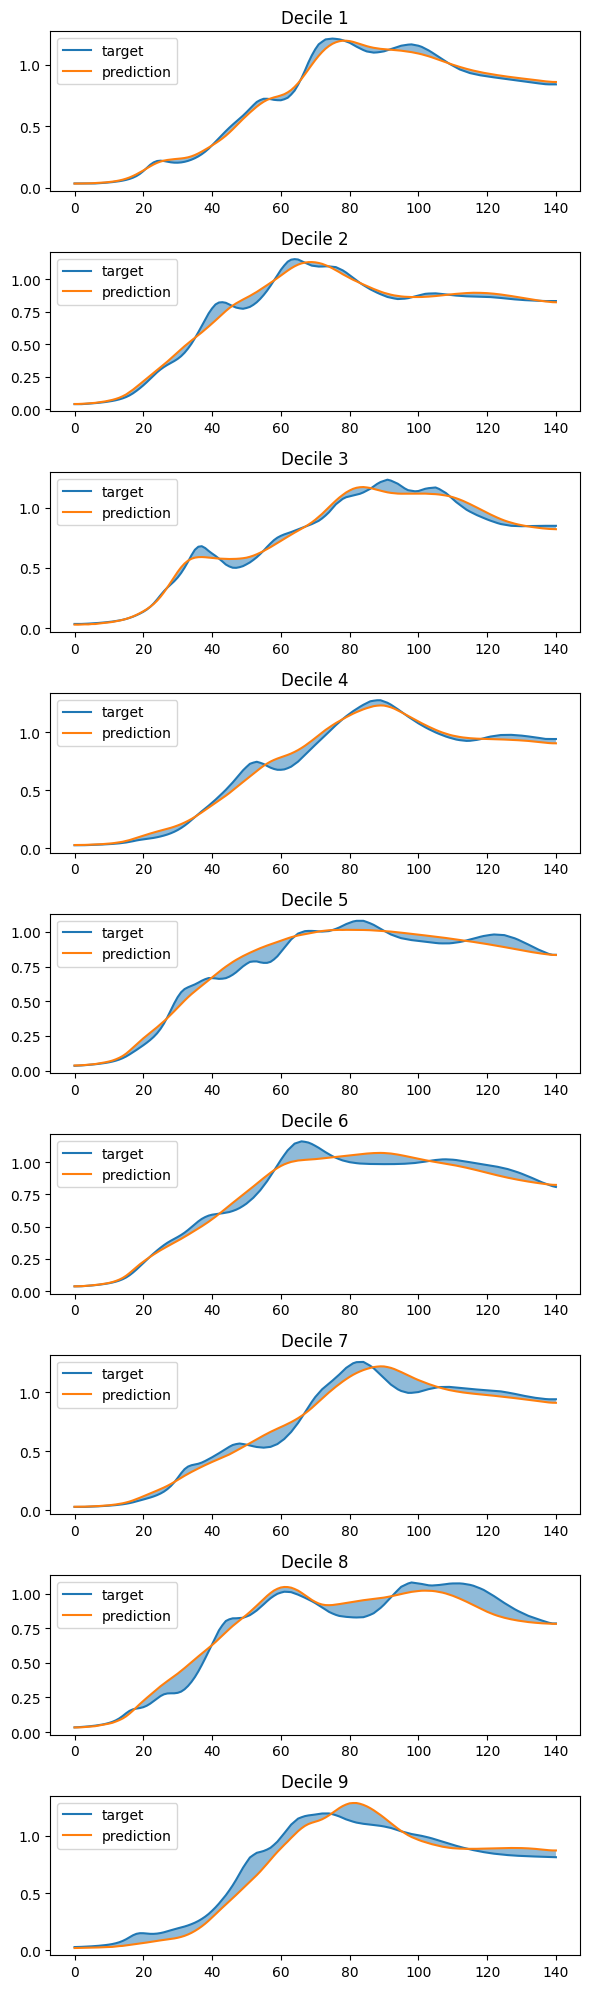

In [53]:
deciles = metrics.deciles
fig, axs = plt.subplots(9, 1, figsize=(6, 20))
for i, (d, ax) in enumerate(zip(deciles, axs)):
    ax.plot(d[0], label="target")
    ax.plot(d[1], label="prediction")
    ax.fill_between( range(len(d[0])), d[0], d[1], alpha=0.5, interpolate=True)
    ax.legend()
    ax.set_title(f"Decile {i+1}")
fig.tight_layout()
fig.show()

In [54]:
MSEs = []
preds = metrics.predictions
targs = metrics.targets

for i in range(len(preds)):
    target = targs[i]
    prediction = preds[i]

    error = target - prediction
    MSEs.append(np.mean(error**2))

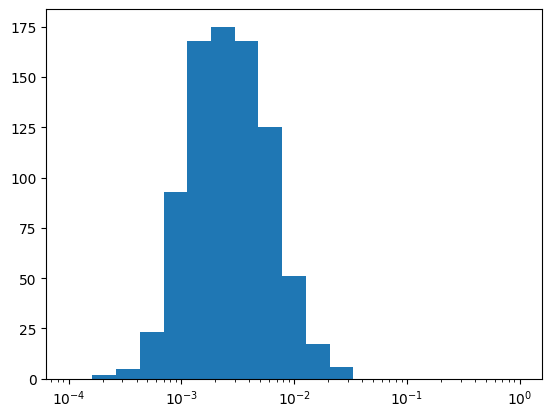

In [55]:
bins = 10**np.linspace(-4, 0, 20) # 20 bins from 10^0 to 10^3
plt.hist(MSEs, bins = bins)
plt.xscale('log')